## Import libraries

In [20]:
import os
import sys
import cv2
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog as skimage_hog
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cityblock, cosine, correlation, sqeuclidean
from sklearn.svm import SVC

## Load data

In [4]:
project_dir = os.getcwd()
project_dir = os.path.dirname(project_dir)

In [6]:
width = 64
height = 64

In [7]:
data_dir = project_dir + "\\data"

train_path = os.path.join(data_dir, "train")
test_path = os.path.join(data_dir, "test")

train_images = []
test_images = []

train_labels = []
test_labels = []

for path in (train_path, test_path):
    if (path.split('\\')[-1] == "train"):
        for dir in os.listdir(path):
            label_path = os.path.join(path, dir)
            label = dir.split('\\')[-1]
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (width, height))
                train_images.append(image)
                train_labels.append(label)
    else:
        for dir in os.listdir(path):
            label_path = os.path.join(path, dir)
            label = dir.split('\\')[-1]
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (width, height))
                test_images.append(image)
                test_labels.append(label)

In [8]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

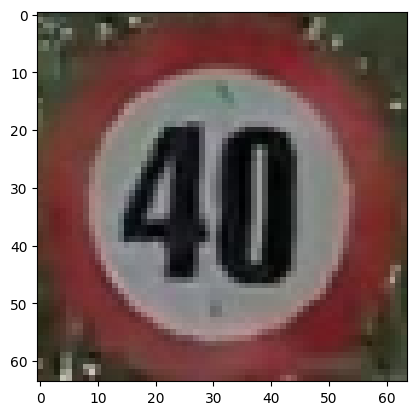

In [9]:
plt.imshow(test_images[0])

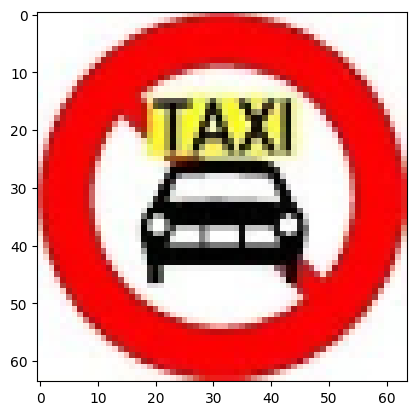

In [10]:
plt.imshow(train_images[1])

## Extract features

In [11]:
def blur_image(image):
    blurred_image = cv2.medianBlur(image, 5)
    return blurred_image

In [12]:
def color_histogram(image):
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    row, column, channel = image.shape[:3]
    size = row * column
    feature = []
    for k in range(channel):
        histogram = np.squeeze(cv2.calcHist([image], [k], None, [32], [0, 256]))
        histogram = histogram / size
        feature.extend(histogram)
    return feature

In [13]:
def hog(image):
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    hog_features = skimage_hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys', transform_sqrt=True, channel_axis=2)
    return hog_features

In [16]:
def extract_features(images):
    # blurred_images = [blur_image(image) for image in images]
    color_features = [color_histogram(image) for image in images]
    hog_features = [hog(image) for image in images]
    combined_features = [np.concatenate((color_feature, hog_feature)) for color_feature, hog_feature in zip(color_features, hog_features)]
    return combined_features

In [33]:
train_features = extract_features(train_images)
joblib.dump(train_features, project_dir + '\joblib\\train_features.joblib')

['d:\\ASUS\\New folder (2)\\Deploy-Traffic-Sign-Classification-through-Images\\joblib\\train_features.joblib']

In [34]:
test_features = extract_features(test_images)
joblib.dump(test_features, project_dir + '\joblib\\test_features.joblib')

['d:\\ASUS\\New folder (2)\\Deploy-Traffic-Sign-Classification-through-Images\\joblib\\test_features.joblib']

## Distance metrics KNN

In [13]:
def chi_square_distance(x, y):
    return cv2.compareHist(np.array(x, dtype=np.float32), np.array(y, dtype=np.float32), cv2.HISTCMP_CHISQR)

def bhattacharyya_distance(x, y):
    return cv2.compareHist(np.array(x, dtype=np.float32), np.array(y, dtype=np.float32), cv2.HISTCMP_BHATTACHARYYA)

def intersection_distance(x, y):
    return 1 - cv2.compareHist(np.array(x, dtype=np.float32), np.array(y, dtype=np.float32), cv2.HISTCMP_INTERSECT)

## Gridsearch KNN

In [19]:
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels_encoded, test_size=0.2, random_state=42)

In [15]:
param_grid = {
    'n_neighbors': [3, 4, 5, 6, 7],
    'weights': ['uniform', 'distance'],
    'leaf_size': [10, 20, 30, 40, 50],
    'metric': [
        cityblock,
        cosine,
        correlation,
        sqeuclidean,
        chi_square_distance,
        bhattacharyya_distance,
        intersection_distance
    ]
}

knn_model = KNeighborsClassifier()
grid_search_knn = GridSearchCV(
    knn_model,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=3
)

grid_search_knn.fit(X_train, y_train)

Fitting 3 folds for each of 350 candidates, totalling 1050 fits
[CV 1/3] END leaf_size=10, metric=<function cityblock at 0x000002AEF13D0F40>, n_neighbors=3, weights=uniform;, score=0.861 total time=   1.3s
[CV 2/3] END leaf_size=10, metric=<function cityblock at 0x000002AEF13D0F40>, n_neighbors=3, weights=uniform;, score=0.852 total time=   1.3s
[CV 3/3] END leaf_size=10, metric=<function cityblock at 0x000002AEF13D0F40>, n_neighbors=3, weights=uniform;, score=0.883 total time=   1.4s
[CV 1/3] END leaf_size=10, metric=<function cityblock at 0x000002AEF13D0F40>, n_neighbors=3, weights=distance;, score=0.886 total time=   1.3s
[CV 2/3] END leaf_size=10, metric=<function cityblock at 0x000002AEF13D0F40>, n_neighbors=3, weights=distance;, score=0.855 total time=   1.2s
[CV 3/3] END leaf_size=10, metric=<function cityblock at 0x000002AEF13D0F40>, n_neighbors=3, weights=distance;, score=0.891 total time=   1.3s
[CV 1/3] END leaf_size=10, metric=<function cityblock at 0x000002AEF13D0F40>, n_n

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [10, 20, 30, 40, 50],
                         'metric': [<function cityblock at 0x000002AEF13D0F40>,
                                    <function cosine at 0x000002AEF13D0C20>,
                                    <function correlation at 0x000002AEF13D0B80>,
                                    <function sqeuclidean at 0x000002AEF13D0AE0>,
                                    <function chi_square_distance at 0x000002AEF76DAC00>,
                                    <function bhattacharyya_distance at 0x000002AEF76D9EE0>,
                                    <function intersection_distance at 0x000002AEF76D9F80>],
                         'n_neighbors': [3, 4, 5, 6, 7],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=3)

In [16]:
best_knn = grid_search_knn.best_estimator_
print(f"Best Params: {grid_search_knn.best_params_}")

best_knn.fit(train_features, train_labels_encoded)

y_preda_knn = best_knn.predict(test_features)

joblib.dump(best_knn, project_dir + '\joblib\\best_knn_model.joblib')

Best Params: {'leaf_size': 10, 'metric': <function cityblock at 0x000002AEF13D0F40>, 'n_neighbors': 3, 'weights': 'distance'}


['best_knn_model_2.joblib']

## Gridsearch SVM

In [22]:
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001], 
    'class_weight': ['balanced', None],  
    'degree': [2, 3, 4],  
    'coef0': [0.0, 0.1, 0.5]  
}

svm_model = SVC(random_state=42)

grid_search_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    cv=3,  
    scoring='accuracy',
    verbose=3,
)

grid_search_svm.fit(X_train, y_train)

Fitting 3 folds for each of 1440 candidates, totalling 4320 fits
[CV 1/3] END C=0.1, class_weight=balanced, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.683 total time=   1.4s
[CV 2/3] END C=0.1, class_weight=balanced, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.623 total time=   1.3s
[CV 3/3] END C=0.1, class_weight=balanced, coef0=0.0, degree=2, gamma=scale, kernel=rbf;, score=0.658 total time=   1.5s
[CV 1/3] END C=0.1, class_weight=balanced, coef0=0.0, degree=2, gamma=scale, kernel=linear;, score=0.810 total time=   0.5s
[CV 2/3] END C=0.1, class_weight=balanced, coef0=0.0, degree=2, gamma=scale, kernel=linear;, score=0.851 total time=   0.5s
[CV 3/3] END C=0.1, class_weight=balanced, coef0=0.0, degree=2, gamma=scale, kernel=linear;, score=0.849 total time=   0.5s
[CV 1/3] END C=0.1, class_weight=balanced, coef0=0.0, degree=2, gamma=scale, kernel=poly;, score=0.735 total time=   0.7s
[CV 2/3] END C=0.1, class_weight=balanced, coef0=0.0, degree=2, gamma=scale, k

GridSearchCV(cv=3, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'coef0': [0.0, 0.1, 0.5], 'degree': [2, 3, 4],
                         'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             scoring='accuracy', verbose=3)

In [23]:
best_svm = grid_search_svm.best_estimator_
# Get the best parameters and score
print("Best parameters:", grid_search_svm.best_params_)
best_svm.fit(train_features, train_labels_encoded)

y_pred_svm = best_svm.predict(test_features)

joblib.dump(best_svm, project_dir + '\joblib\\best_svm_model.joblib')

Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': 0.0, 'degree': 4, 'gamma': 0.1, 'kernel': 'poly'}


['d:\\ASUS\\New folder (2)\\Deploy-Traffic-Sign-Classification-through-Images\\joblib\\best_svm_model.joblib']

## Predict on test images

In [24]:
report = classification_report(test_labels_encoded, y_pred_svm, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

         Cam       0.94      0.91      0.93        34
      Chidan       0.88      0.85      0.86        33
    Hieulenh       0.93      0.87      0.90        31
    Nguyhiem       1.00      1.00      1.00        29
         Phu       0.74      0.87      0.80        23

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150



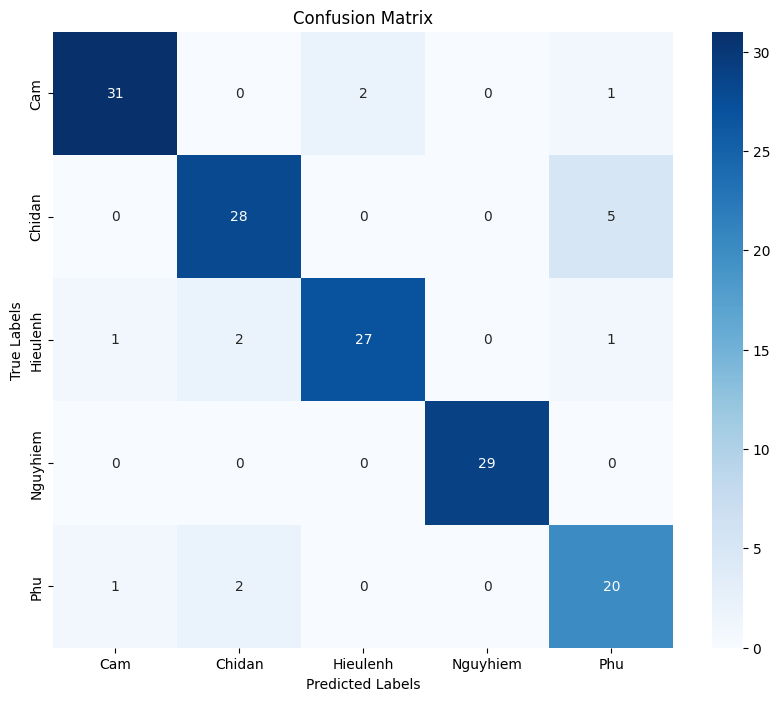

In [25]:
heatmap_label = confusion_matrix(test_labels_encoded, y_pred_svm)

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_label, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

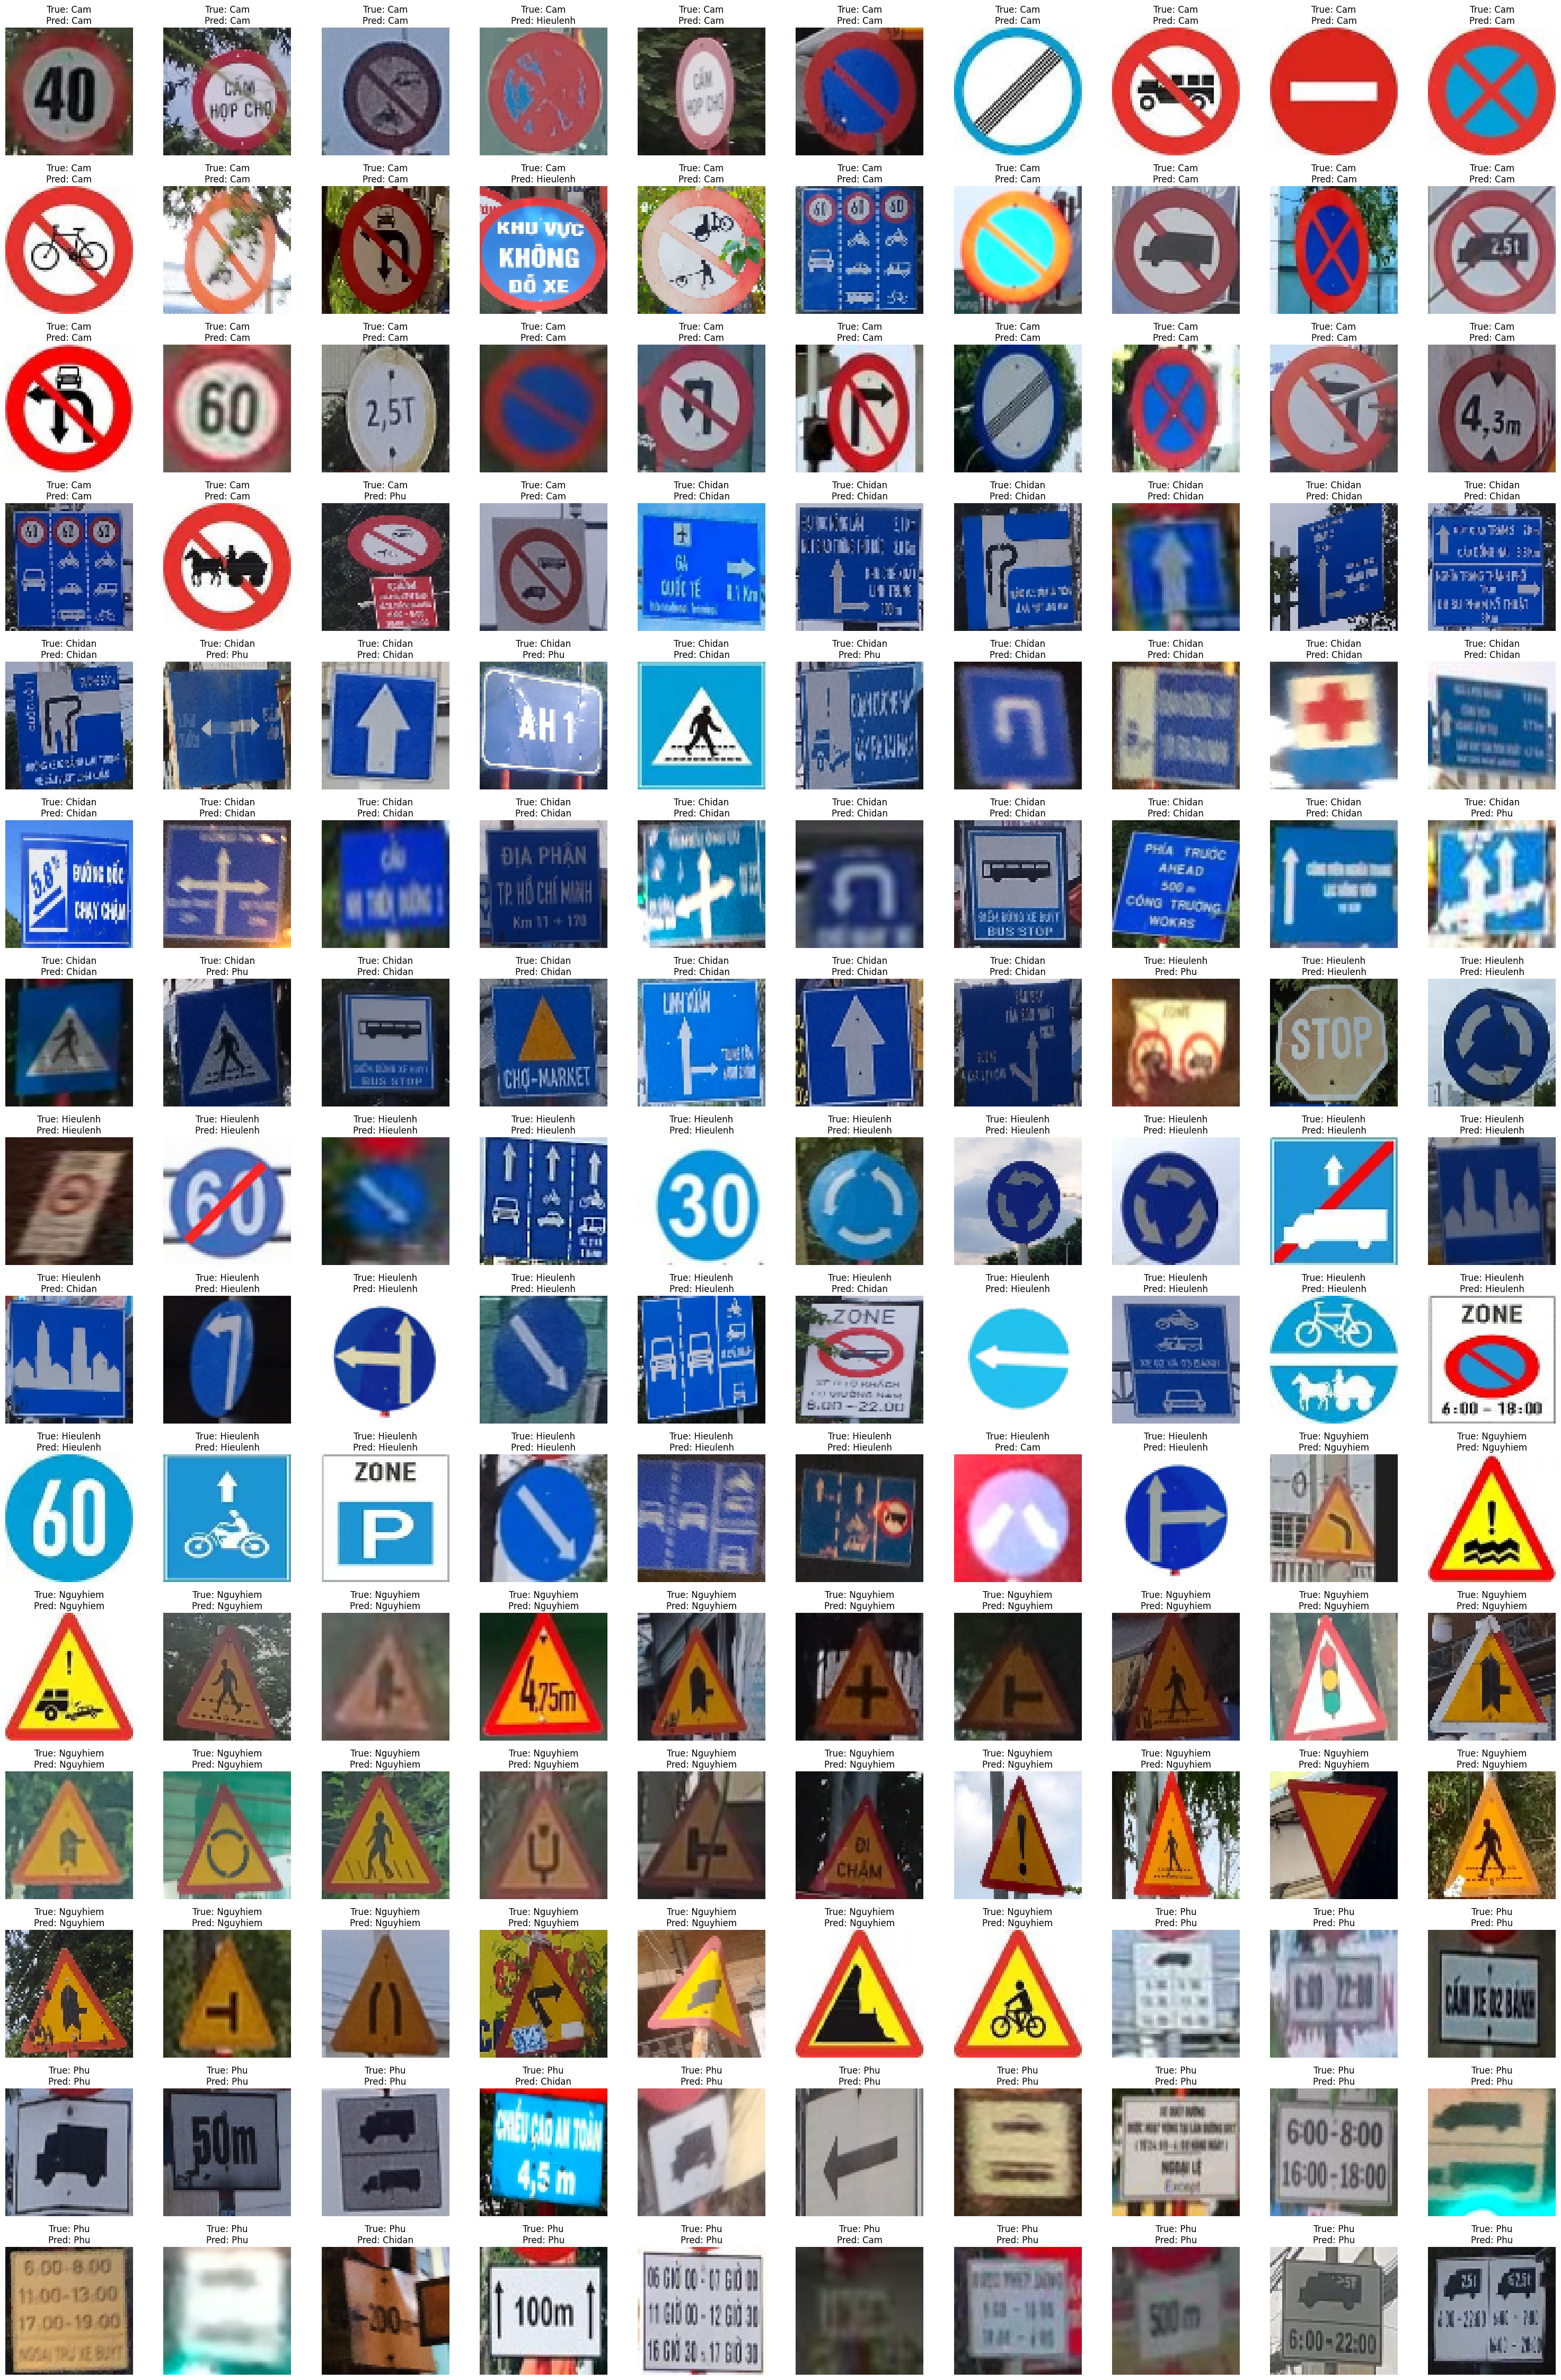

In [26]:
n_columns = 10
n_rows = math.ceil(len(test_images) / n_columns)

fig, axes = plt.subplots(n_rows, n_columns, figsize=(30, n_rows * 3))

for idx, (image, true_label, pred_label) in enumerate(zip(test_images, test_labels_encoded, y_pred_svm)):
    row = idx // n_columns
    col = idx % n_columns
    
    axes[row, col].imshow(image)
    axes[row, col].set_title(f'True: {label_encoder.classes_[true_label]}\nPred: {label_encoder.classes_[pred_label]}')
    axes[row, col].axis('off')

for ax in axes.flat:
    if not ax.has_data():
        ax.axis('off')

plt.tight_layout()
plt.show()

## Save grid search results

In [31]:
def save_grid_search_results_with_timestamp(grid_search, image_size, project_dir):
    results_dir = os.path.join(project_dir)
    os.makedirs(results_dir, exist_ok=True)
    current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    file_path = os.path.join(results_dir, f'grid_search_results_{current_time}.txt')
    
    # Lấy tất cả kết quả từ cv_results_
    cv_results = grid_search.cv_results_
    
    # Chuẩn bị nội dung ghi vào file
    results = [
        f"Date and Time: {current_time}",
        f"Image Size: {image_size}",
        f"Best Parameters: {grid_search.best_params_}",
        f"Best Score: {grid_search.best_score_}",
        "Detailed Grid Search Results:"
    ]
    
    # Lấy các tham số của mỗi lần huấn luyện
    param_keys = [key for key in cv_results if key.startswith("param_")]
    score_keys = [key for key in cv_results if key.startswith("mean") or key.startswith("std")]
    
    # In từng kết quả từ cv_results_
    for i in range(len(cv_results['params'])):
        result = [f"Result {i + 1}:"]
        
        # Thêm các tham số của lần chạy hiện tại
        for key in param_keys:
            result.append(f"  {key}: {cv_results[key][i]}")
        
        # Thêm điểm số của lần chạy hiện tại
        for key in score_keys:
            result.append(f"  {key}: {cv_results[key][i]}")
        
        results.extend(result)
    
    # Ghi nội dung vào file .txt
    with open(file_path, 'w') as f:
        f.write("\n".join(results))
    
    print(f'Results saved to {file_path}')

In [23]:
image_size = (width, height)
save_grid_search_results_with_timestamp(grid_search_knn, image_size, project_dir + '\grid_search_results\knn')

Results saved to E:\Documents\CS231\final_project\grid_search_results\grid_search_results_2024-10-26_08-44-49.txt


In [32]:
image_size = (width, height)
save_grid_search_results_with_timestamp(grid_search_svm, image_size, project_dir + '\grid_search_results\svm')

Results saved to d:\ASUS\New folder (2)\Deploy-Traffic-Sign-Classification-through-Images\grid_search_results\svm\grid_search_results_2024-10-27_22-56-40.txt
